In [2]:
import os

import numpy as np
import pandas as pd 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
# This Jupyter Notebook implements the backtest of switching-between spot-delivery arbitrages
# you can find the picture of formulas among files, which can help you modify, improve, and possibly
# To debug the model.

#this cell gets paths for historical data csv files

contract_date = "230630"
base_addr = "/Users/ahmetsalih/PycharmProjects/interest_calc/"
spot_path = base_addr + contract_date + "/SPOT"
del_path = base_addr + contract_date + "/DELIVERY"

contract_date_numerical = datetime.datetime(int(contract_date[0:2])+2000, int(contract_date[2:4]), int(contract_date[4:6]))
contract_date_numerical = contract_date_numerical.timestamp() * 1000

dir_list_spot = os.listdir(spot_path)
dir_list_delivery = os.listdir(del_path)

print(dir_list_spot)
print("------------------------")
print(dir_list_delivery)    

['LTCUSD_PERP-1m-2023-04.csv', 'ETHUSD_PERP-1m-2023-04.csv', 'BNBUSD_PERP-1m-2022-12.csv', 'ETHUSD_PERP-1m-2023-05.csv', 'LTCUSD_PERP-1m-2023-05.csv', 'DOTUSD_PERP-1m-2023-06.csv', 'DOTUSD_PERP-1m-2023-04.csv', 'ADAUSD_PERP-1m-2022-12.csv', 'ETHUSD_PERP-1m-2023-06.csv', 'LTCUSD_PERP-1m-2023-06.csv', 'DOTUSD_PERP-1m-2023-05.csv', 'DOTUSD_PERP-1m-2023-01.csv', 'LTCUSD_PERP-1m-2023-02.csv', 'ETHUSD_PERP-1m-2023-02.csv', '.DS_Store', 'ETHUSD_PERP-1m-2023-03.csv', 'LTCUSD_PERP-1m-2023-03.csv', 'DOTUSD_PERP-1m-2023-02.csv', 'LTCUSD_PERP-1m-2023-01.csv', 'ETHUSD_PERP-1m-2023-01.csv', 'DOTUSD_PERP-1m-2023-03.csv', 'BTCUSD_PERP-1m-2022-12.csv', 'LINKUSD_PERP-1m-2023-06.csv', 'XRPUSD_PERP-1m-2023-02.csv', 'BCHUSD_PERP-1m-2023-05.csv', 'BCHUSD_PERP-1m-2023-04.csv', 'XRPUSD_PERP-1m-2023-03.csv', 'LINKUSD_PERP-1m-2023-05.csv', 'XRPUSD_PERP-1m-2023-01.csv', 'BCHUSD_PERP-1m-2023-06.csv', 'LINKUSD_PERP-1m-2023-04.csv', 'XRPUSD_PERP-1m-2023-04.csv', 'BCHUSD_PERP-1m-2023-03.csv', 'BCHUSD_PERP-1m-2023-02

In [4]:
# this cell gets the csv datas, aligns their time, and creates dataframe to plot the yearly interest of pairs
# annualized

pair_names_to_file_paths_spot = {}
pair_names_to_file_paths_delivery = {}

pair_data_spot = {}
pair_data_delivery = {}

#column_names = ["open_time","open","high","low","close","volume","close_time","quote_volume","count","taker_buy_volume","taker_buy_quote_volume","ignore"]
for file_name in dir_list_spot:
    pair_name = file_name.split("_")[0]
    if(not pair_name.endswith("USD")):continue
    if(pair_name not in pair_names_to_file_paths_spot.keys()):
        pair_names_to_file_paths_spot[pair_name] = [spot_path + "/" + file_name]
    else:
        pair_names_to_file_paths_spot[pair_name].append(spot_path + "/" + file_name)
    
for file_name in dir_list_delivery:
    pair_name = file_name.split("_")[0]
    
    if(not (pair_name.endswith("USD") or pair_name.endswith("USDT"))):continue
    
    if(pair_name not in pair_names_to_file_paths_delivery.keys()):
        pair_names_to_file_paths_delivery[pair_name] = [del_path + "/" + file_name]
    else:
        pair_names_to_file_paths_delivery[pair_name].append(del_path + "/" + file_name)

for pair_name in pair_names_to_file_paths_spot.keys():
    dataframes = []
    for file_path in  pair_names_to_file_paths_spot[pair_name]:
        dataframes.append( pd.read_csv(file_path) )
    pair_data_spot[pair_name] = pd.concat(dataframes)
    pair_data_spot[pair_name] = pair_data_spot[pair_name].sort_values(by=['open_time'], ignore_index=True)
    pair_data_spot[pair_name] = pair_data_spot[pair_name].drop_duplicates(subset=['open_time'], ignore_index=True)

for pair_name in pair_names_to_file_paths_delivery.keys():
    pair_data_delivery[pair_name] = pd.concat(map(pd.read_csv, pair_names_to_file_paths_delivery[pair_name]))
    pair_data_delivery[pair_name] = pair_data_delivery[pair_name].sort_values(by=['open_time'], ignore_index=True)
    pair_data_delivery[pair_name] = pair_data_delivery[pair_name].drop_duplicates(subset=['open_time'], ignore_index=True)

all_min_time = 0
all_max_time = contract_date_numerical

for pair_name in pair_names_to_file_paths_spot.keys():
    min_time = max(min(pair_data_delivery[pair_name]["open_time"]), min(pair_data_spot[pair_name]["open_time"]))
    max_time = min(max(pair_data_delivery[pair_name]["open_time"]), max(pair_data_spot[pair_name]["open_time"]))
    
    all_min_time = max(all_min_time, min_time)
    all_max_time = min(all_max_time, max_time)

for pair_name in pair_names_to_file_paths_spot.keys():
    pair_data_delivery[pair_name] = pair_data_delivery[pair_name][pair_data_delivery[pair_name]["open_time"] >= all_min_time]
    pair_data_delivery[pair_name] = pair_data_delivery[pair_name][pair_data_delivery[pair_name]["open_time"] <= all_max_time]
    
    pair_data_spot[pair_name] = pair_data_spot[pair_name][pair_data_spot[pair_name]["open_time"] >= all_min_time]
    pair_data_spot[pair_name] = pair_data_spot[pair_name][pair_data_spot[pair_name]["open_time"] <= all_max_time]

pair_interest_rates = []
times = []
del_prices = []
spot_prices = []
remainig_time = []
pair = []
for pair_name in pair_data_spot.keys():
    for i in range(len(pair_data_spot[pair_name])):
        if(i > len(pair_data_spot[pair_name])*0.95):continue
        pair.append(pair_name)
        #this_pt = datetime.datetime.fromtimestamp(pair_data_spot[pair_name].iloc[i]["open_time"]/1000)
        #times.append(this_pt.strftime("%m/%d/%Y %H:%M"))
        times.append(pair_data_spot[pair_name].iloc[i]["open_time"])
        
        rem_time = (contract_date_numerical - pair_data_spot[pair_name].iloc[i]["open_time"]) / 86400000 
        remainig_time.append(rem_time)
        
        row_del = pair_data_delivery[pair_name].iloc[i]
        row_spot = pair_data_spot[pair_name].iloc[i]
        
        is_cls = False
        if(row_del["close"]/row_spot["close"] > row_del["open"]/row_spot["open"]):
            is_cls = True
        
        interest_rate = -1
        if(is_cls):
            interest_rate = 100* (row_del["close"]-row_spot["close"])/row_spot["close"] * 365 / rem_time
            del_prices.append(row_del["close"])
            spot_prices.append(row_spot["close"])
        else:
            interest_rate = 100* (row_del["open"]-row_spot["open"])/row_spot["open"] * 365 / rem_time
            del_prices.append(row_del["open"])
            spot_prices.append(row_spot["open"])
        
        pair_interest_rates.append(interest_rate)

pair_dict = {
    "interest_rate": pair_interest_rates,
    "time": times,
    "del_prices": del_prices,
    "spot_prices": spot_prices,
    "remaining_time": remainig_time,
    "pair": pair
}
pair_df = pd.DataFrame.from_dict(pair_dict)


In [5]:
pair_data_spot["BTCUSD"]

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
42131,1672380660000,16554.000000,16555.028079,16554.000000,16554.147734,0,1672380719999,0,60,0,0,0
42132,1672380720000,16554.959162,16556.025485,16554.284436,16555.084198,0,1672380779999,0,60,0,0,0
42133,1672380780000,16554.000000,16554.100000,16547.900000,16547.900000,0,1672380839999,0,60,0,0,0
42134,1672380840000,16547.900000,16548.653358,16547.800000,16548.653358,0,1672380899999,0,60,0,0,0
42135,1672380900000,16548.404524,16550.089356,16548.304483,16550.089356,0,1672380959999,0,60,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
303656,1688072160000,30382.251851,30392.300000,30381.200000,30383.732941,0,1688072219999,0,60,0,0,0
303657,1688072220000,30383.433474,30386.100000,30383.100000,30386.100000,0,1688072279999,0,60,0,0,0
303658,1688072280000,30386.100000,30392.161424,30386.100000,30391.909674,0,1688072339999,0,60,0,0,0
303659,1688072340000,30391.496862,30391.937891,30386.186335,30386.186335,0,1688072399999,0,60,0,0,0


AttributeError: 'list' object has no attribute 'get_figure'

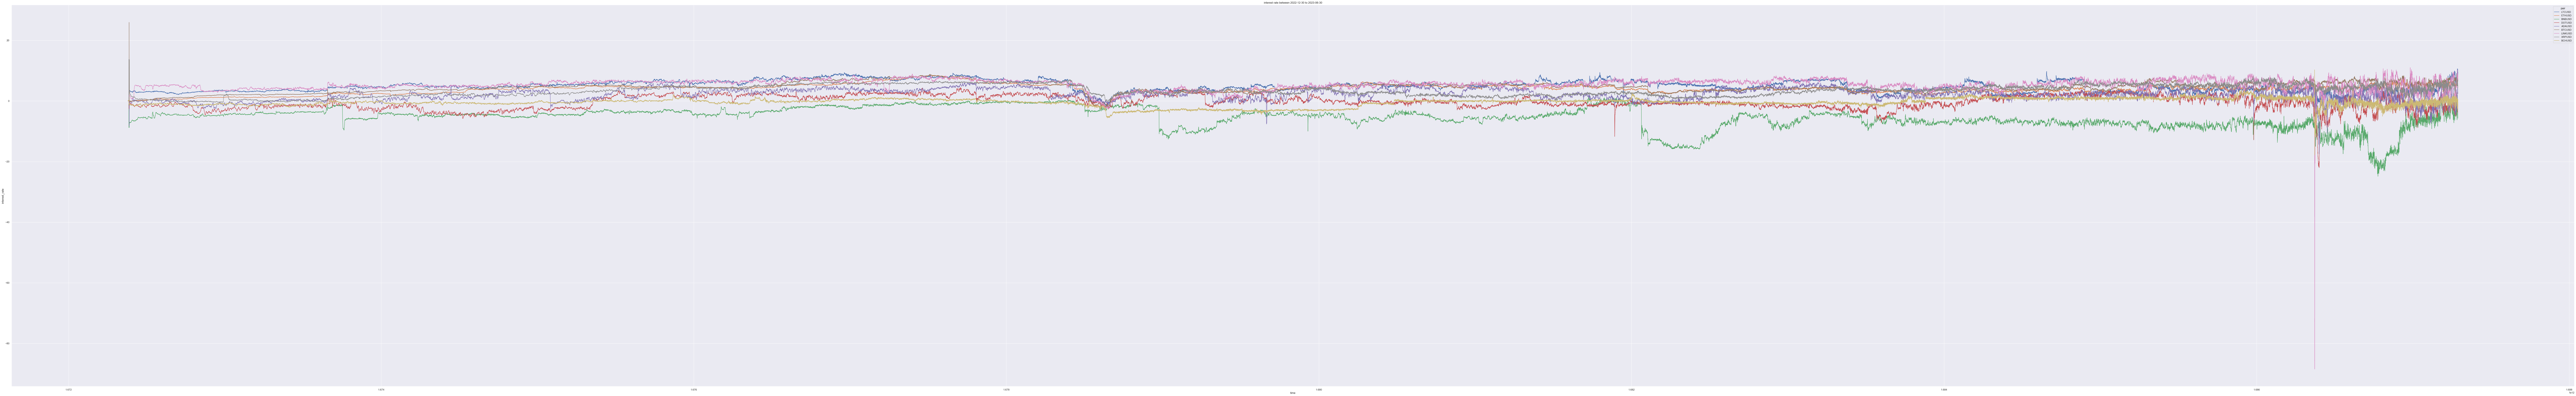

In [12]:
#this cell plots the yearly interest rates for different pairs
sns.set(rc={"figure.figsize":(200, 30)})
fig = (sns.lineplot(data=pair_df, x='time', y='interest_rate', hue='pair',errorbar=None).
 set(title = f"interest rate between {datetime.datetime.fromtimestamp(all_min_time//1000).date()} to {datetime.datetime.fromtimestamp(all_max_time//1000).date()}"))

#fig.get_figure().savefig("output.png")

In [13]:
for pair in pair_data_spot.keys():
    print(pair)
    length = len(pair_data_spot[pair])
    print(pair, length)

LTCUSD
LTCUSD 261530
ETHUSD
ETHUSD 261530
BNBUSD
BNBUSD 261530
DOTUSD
DOTUSD 261530
ADAUSD
ADAUSD 261530
BTCUSD
BTCUSD 261530
LINKUSD
LINKUSD 261530
XRPUSD
XRPUSD 261530
BCHUSD
BCHUSD 261530


In [14]:
# this cell does the backtesting, and traces the pairs we should take along 6 month period
# you may need to modify iopub_data_rate_limit to run this cell
# also refer to the formulas for debugging or as reference

current_arbing_pair = None
spot_price_when_bought = None
future_price_when_bought = None
spot_fees = 0.001
future_fees = 0.0005
total_benefits = {}

profit = 0
track_of_positions = []
max_total_benefit =  -10000000
max_benefit_pair = None

for pair in pair_data_spot.keys():
        total_benefits[pair] = (1/pair_data_spot[pair].iloc[0]["open"])*(pair_data_delivery[pair].iloc[0]["open"] - pair_data_spot[pair].iloc[0]["open"])
        if(total_benefits[pair] > max_total_benefit):
            max_total_benefit = total_benefits[pair]
            max_benefit_pair = pair
            
current_arbing_pair = max_benefit_pair        
spot_price_when_bought = pair_data_spot[max_benefit_pair].iloc[0]["open"]
future_price_when_bought = pair_data_delivery[max_benefit_pair].iloc[0]["open"]
time = datetime.datetime.fromtimestamp(pair_data_spot[max_benefit_pair].iloc[0]["open_time"]//1000)
track_of_positions.append({"pair": max_benefit_pair, "time":time.strftime("%m/%d/%Y %H:%M"), "total_benefit": max_total_benefit, "profit": profit})

for i in range(len(pair_data_spot["BTCUSD"])):
    max_total_benefit =  -1000000
    max_benefit_pair = None
    for pair in pair_data_spot.keys():
        total_benefits[pair] = (1/pair_data_spot[pair].iloc[i]["open"])*(pair_data_delivery[pair].iloc[i]["open"] - pair_data_spot[pair].iloc[i]["open"])
        if(total_benefits[pair] > max_total_benefit):
            max_total_benefit = total_benefits[pair]
            max_benefit_pair = pair
        
    current_total_benefit = (1/spot_price_when_bought)*(pair_data_delivery[current_arbing_pair].iloc[i]["open"] - pair_data_spot[current_arbing_pair].iloc[i]["open"])
    trading_fees_position_change = (1 + spot_price_when_bought/pair_data_spot[current_arbing_pair].iloc[i]["open"])*(spot_fees + future_fees)
    
    if(max_total_benefit - trading_fees_position_change > current_total_benefit)and(max_benefit_pair != current_arbing_pair):
        delta_profit_wo_fees = + 1/spot_price_when_bought * (future_price_when_bought - spot_price_when_bought) - current_total_benefit
        delta_profit = delta_profit_wo_fees - trading_fees_position_change
        profit += delta_profit               

        current_arbing_pair = max_benefit_pair        
        spot_price_when_bought = pair_data_spot[max_benefit_pair].iloc[i]["open"]
        future_price_when_bought = pair_data_delivery[max_benefit_pair].iloc[i]["open"]
        time = datetime.datetime.fromtimestamp(pair_data_spot[max_benefit_pair].iloc[i]["open_time"]//1000)
        track_of_positions.append({"pair": max_benefit_pair,
                                   "time":time.strftime("%m/%d/%Y %H:%M"),
                                   "trade cost": trading_fees_position_change,
                                   "old benefit": current_total_benefit,
                                   "new benefit": max_total_benefit, 
                                   "delta profit": delta_profit,
                                  "delta profit without fees": delta_profit_wo_fees,
                                  "profit": profit})
delta_profit_wo_fees = + 1/spot_price_when_bought * (future_price_when_bought - spot_price_when_bought)
profit += delta_profit_wo_fees
print(profit)
for position in track_of_positions:
    print(position)

0.1376718579717933
{'pair': 'BCHUSD', 'time': '12/30/2022 09:11', 'total_benefit': 0.0009047111967771434, 'profit': 0}
{'pair': 'XRPUSD', 'time': '12/30/2022 10:38', 'trade cost': 0.003021628574138621, 'old benefit': -0.0039490784066363895, 'new benefit': 0.06816256333830102, 'delta profit': 0.0018321610292749116, 'delta profit without fees': 0.0048537896034135325, 'profit': 0.0018321610292749116}
{'pair': 'BTCUSD', 'time': '12/30/2022 11:02', 'trade cost': 0.002995308830671466, 'old benefit': 0.06807198211624442, 'new benefit': 0.12904702044773583, 'delta profit': -0.0029047276086148644, 'delta profit without fees': 9.058122205660157e-05, 'profit': -0.0010725665793399528}
{'pair': 'XRPUSD', 'time': '12/30/2022 11:07', 'trade cost': 0.0029993985414877118, 'old benefit': 0.060465321504574496, 'new benefit': 0.06762359916987849, 'delta profit': 0.06558230040167362, 'delta profit without fees': 0.06858169894316134, 'profit': 0.06450973382233367}
{'pair': 'LTCUSD', 'time': '12/30/2022 11:4

[Text(0.5, 1.0, 'profit graph of strategy during the 6 month period for contracts date 230630')]

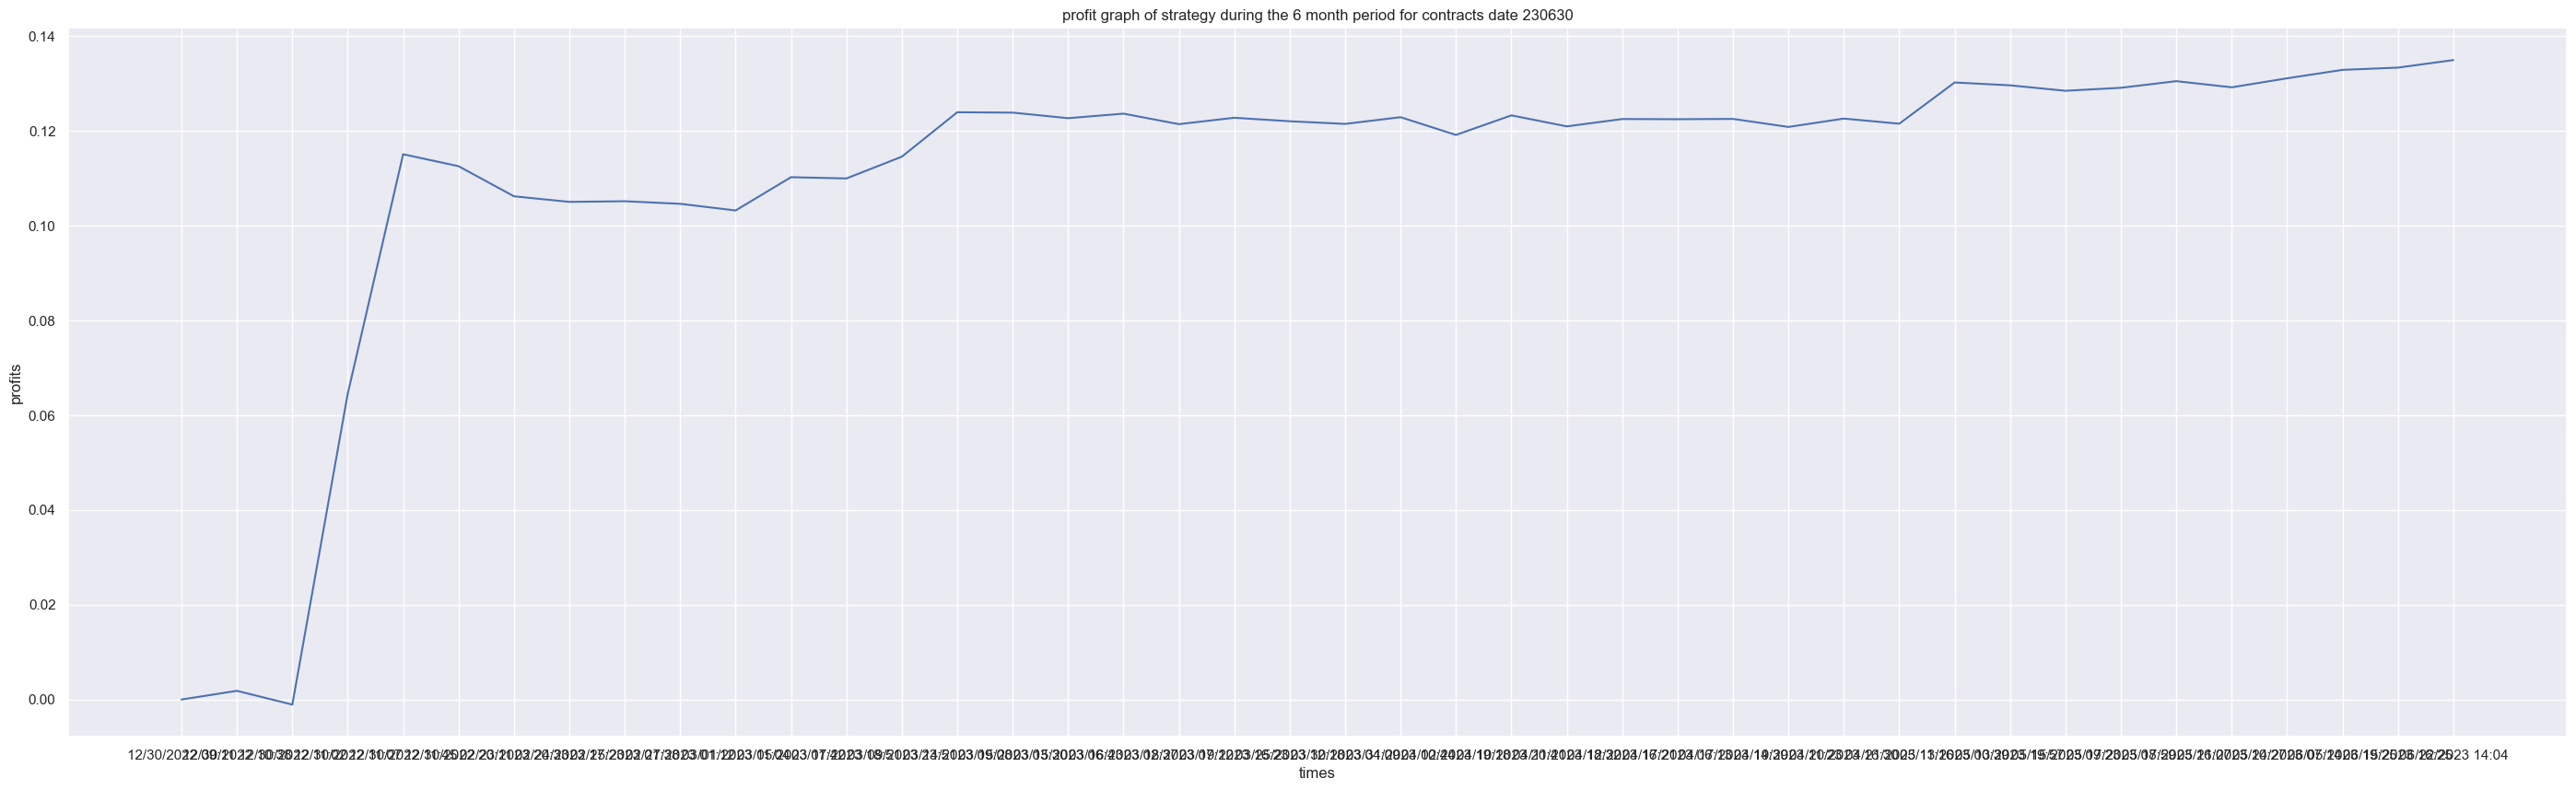

In [15]:
# this cell plots the result of backtest

sns.set(rc={"figure.figsize":(35, 10)})
profits = []
times = []
data_dict = {"profits": [], "times": []}
for i in range(len(track_of_positions)):
    data_dict["profits"].append(track_of_positions[i]["profit"])
    data_dict["times"].append(track_of_positions[i]["time"])

df_data = pd.DataFrame.from_dict(data_dict)

sns.lineplot(data=df_data, x='times', y='profits',errorbar=None).set(title = f"profit graph of strategy during the 6 month period for contracts date {contract_date}")

In [19]:
len(track_of_positions)

22

In [26]:
!jupyter notebook --NotebookApp.iopub_data_rate_limit=100000000

[I 2024-06-25 16:14:04.861 ServerApp] jupyter_lsp | extension was successfully linked.
[I 2024-06-25 16:14:04.862 ServerApp] jupyter_server_terminals | extension was successfully linked.
[W 2024-06-25 16:14:04.863 LabApp] 'iopub_data_rate_limit' has moved from NotebookApp to ServerApp. This config will be passed to ServerApp. Be sure to update your config before our next release.
[W 2024-06-25 16:14:04.864 ServerApp] ServerApp.iopub_data_rate_limit config is deprecated in 2.0. Use ZMQChannelsWebsocketConnection.iopub_data_rate_limit.
[I 2024-06-25 16:14:04.864 ServerApp] jupyterlab | extension was successfully linked.
[I 2024-06-25 16:14:04.865 ServerApp] notebook | extension was successfully linked.
[I 2024-06-25 16:14:05.025 ServerApp] notebook_shim | extension was successfully linked.
[I 2024-06-25 16:14:05.056 ServerApp] notebook_shim | extension was successfully loaded.
[I 2024-06-25 16:14:05.057 ServerApp] jupyter_lsp | extension was successfully loaded.
[I 2024-06-25 16:14:05.05